In [1]:
import keras
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt

from keras import layers
from keras import regularizers
from keras.layers import Dropout
from keras.utils import np_utils
from sklearn import preprocessing
from keras.models import Sequential
from sklearn.utils import class_weight
from sklearn.impute import SimpleImputer
from keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import SGD, Adam
from keras.layers import Input, Dense, Activation
from sklearn.metrics import confusion_matrix as cm
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report as cr

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
df = pd.read_csv('/content/drive/MyDrive/preprocessed_file_v1_filtered', 
                 compression = "zip", header = 0, index_col = 0, sep = "\t")

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (1350,1351,1352) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [4]:
df = df.replace("Unknown", np.nan)
df = df.replace("Not Applicable", np.nan)
df = df.replace("Not Collected", np.nan)
df = df.replace("Not collected", np.nan)
df = df.replace("Not Released", np.nan)

In [5]:
data = df.drop("CANCER_TYPE", axis = 1)
labels = df["CANCER_TYPE"]

In [6]:
for x in data[["SEX", "ETHNICITY", "PRIMARY_RACE", "DEAD"]]:
    data[x], _ = pd.factorize(data[x])

In [7]:
imp = SimpleImputer(missing_values = np.nan, strategy = "constant", fill_value = -1)
data[["YEAR_CONTACT", "YEAR_DEATH"]] = imp.fit_transform(data[["YEAR_CONTACT", "YEAR_DEATH"]])
imp = SimpleImputer(missing_values = '>89', strategy = "constant", fill_value = -1)
data[["YEAR_CONTACT", "YEAR_DEATH"]] = imp.fit_transform(data[["YEAR_CONTACT", "YEAR_DEATH"]])
imp = SimpleImputer(missing_values = '<18', strategy = "constant", fill_value = -1)
data[["YEAR_CONTACT", "YEAR_DEATH"]] = imp.fit_transform(data[["YEAR_CONTACT", "YEAR_DEATH"]])

In [8]:
data = data.astype(int)

In [9]:
print(labels.unique(), len(labels.unique()))

['Glioma' 'Leukemia' 'Thyroid Cancer' 'Hepatobiliary Cancer'
 'Mature B-Cell Neoplasms' 'Non-Small Cell Lung Cancer'
 'Soft Tissue Sarcoma' 'Pancreatic Cancer' 'Head and Neck Cancer'
 'Esophagogastric Cancer' 'Melanoma' 'Breast Cancer' 'Endometrial Cancer'
 'Colorectal Cancer' 'Prostate Cancer' 'Renal Cell Carcinoma'
 'Bladder Cancer' 'Ovarian Cancer'] 18


In [10]:
encoder = preprocessing.LabelEncoder()
classes = encoder.fit_transform(labels)

In [11]:
x_train, x_test, y_train, y_test = train_test_split(
									data, classes, 
									test_size = 0.2, 
									random_state = 0) 

print(y_train.shape)
print(x_train.shape)
print(y_test.shape)
print(x_test.shape)

(78067,)
(78067, 1351)
(19517,)
(19517, 1351)


In [13]:
learning_rate = 0.1
opt = 'ADAM'
size_batch = 128
nb_epochs = 50

In [14]:
#10th try: added patient data

model = Sequential()	
	
model.add(	
	Dense(512, input_dim = x_train.shape[1], activation = 'relu'))

model.add(Dropout(0.5))

model.add(	
	Dense(128, activation = 'relu'))

model.add(Dropout(0.3))

model.add(	
	Dense(32, activation = 'relu',
	      kernel_regularizer = regularizers.l2(0.3)))
	
model.add(	
	Dense(len(labels.unique()), activation = 'softmax',
	      kernel_regularizer = regularizers.l2(0.3)))
	
model.compile(optimizer = opt,	
						loss = 'sparse_categorical_crossentropy',	
						metrics = ["accuracy"])	

In [15]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 512)               692224    
                                                                 
 dropout (Dropout)           (None, 512)               0         
                                                                 
 dense_1 (Dense)             (None, 128)               65664     
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_2 (Dense)             (None, 32)                4128      
                                                                 
 dense_3 (Dense)             (None, 18)                594       
                                                                 
Total params: 762,610
Trainable params: 762,610
Non-trai

In [16]:
es = EarlyStopping(
  monitor = 'val_accuracy', mode = 'max', 
	verbose = 1, patience = 30)

In [17]:
class_weights = class_weight.compute_class_weight(class_weight="balanced", classes=np.unique(y_train), y=y_train)
class_weights_d = {l:c for l,c in zip(np.unique(y_train), class_weights)}

In [18]:
history = model.fit(
	x_train, y_train, 
	validation_data = (x_test, y_test), 
	batch_size = size_batch, 
  epochs = nb_epochs, 
  class_weight = class_weights_d,
	verbose = 1, callbacks = [es])

Epoch 1/50
610/610 [==============================] - 11s 17ms/step - loss: 15.5319 - accuracy: 0.0664 - val_loss: 5.9765 - val_accuracy: 0.0695
Epoch 2/50
610/610 [==============================] - 10s 16ms/step - loss: 4.1505 - accuracy: 0.0661 - val_loss: 3.2633 - val_accuracy: 0.0681
Epoch 3/50
610/610 [==============================] - 10s 17ms/step - loss: 2.9877 - accuracy: 0.0639 - val_loss: 2.8733 - val_accuracy: 0.0581
Epoch 4/50
610/610 [==============================] - 10s 17ms/step - loss: 2.8124 - accuracy: 0.0609 - val_loss: 2.8151 - val_accuracy: 0.0631
Epoch 5/50
610/610 [==============================] - 10s 16ms/step - loss: 2.7780 - accuracy: 0.0590 - val_loss: 2.8124 - val_accuracy: 0.0701
Epoch 6/50
610/610 [==============================] - 10s 17ms/step - loss: 2.7686 - accuracy: 0.0583 - val_loss: 2.8030 - val_accuracy: 0.0780
Epoch 7/50
610/610 [==============================] - 10s 16ms/step - loss: 2.7643 - accuracy: 0.0591 - val_loss: 2.7987 - val_accuracy

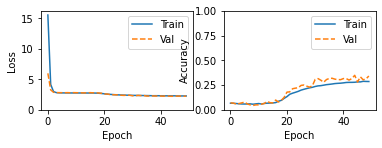

In [19]:
metrics = ['loss', 'accuracy']
for n, metric in enumerate(metrics):
  name = metric.replace("_"," ").capitalize()
  plt.subplot(2,2,n+1)
  plt.plot(history.epoch, history.history[metric],  label='Train')
  plt.plot(history.epoch, history.history['val_'+metric], linestyle="--", label='Val')
  plt.xlabel('Epoch')
  plt.ylabel(name)
  if metric == 'loss':
    plt.ylim([0, plt.ylim()[1]])
  elif metric == 'auc':
    plt.ylim([0.8,1])
  else:
    plt.ylim([0,1])

  plt.legend()

